## Libraries

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading & Initial Inspection

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Infosys_Spring_Board/Dataset/city_hour.csv')

print("Shape:", df.shape)
print(df.head())
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values(['City', 'Datetime']).reset_index(drop=True)
print(df.info())
print(df.describe())

Shape: (707875, 16)
        City             Datetime  PM2.5  PM10    NO    NO2    NOx  NH3    CO  \
0  Ahmedabad  2015-01-01 01:00:00    NaN   NaN  1.00  40.01  36.37  NaN  1.00   
1  Ahmedabad  2015-01-01 02:00:00    NaN   NaN  0.02  27.75  19.73  NaN  0.02   
2  Ahmedabad  2015-01-01 03:00:00    NaN   NaN  0.08  19.32  11.08  NaN  0.08   
3  Ahmedabad  2015-01-01 04:00:00    NaN   NaN  0.30  16.45   9.20  NaN  0.30   
4  Ahmedabad  2015-01-01 05:00:00    NaN   NaN  0.12  14.90   7.85  NaN  0.12   

      SO2      O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
0  122.07     NaN      0.0      0.0     0.0  NaN        NaN  
1   85.90     NaN      0.0      0.0     0.0  NaN        NaN  
2   52.83     NaN      0.0      0.0     0.0  NaN        NaN  
3   39.53  153.58      0.0      0.0     0.0  NaN        NaN  
4   32.63     NaN      0.0      0.0     0.0  NaN        NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707875 entries, 0 to 707874
Data columns (total 16 columns):
 #   Colum

## Data Cleaning & Preprocessing

In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')

def fill_missing_timestamps(city_df):
    full_range = pd.date_range(city_df.index.min(), city_df.index.max(), freq='h')
    return city_df.reindex(full_range)

cleaned = (
    df.groupby('City', group_keys=False)
      .apply(fill_missing_timestamps)
)

cleaned = cleaned.reset_index().rename(columns={'index': 'Timestamp'})

print("Cleaned shape:", cleaned.shape)
cleaned.head()

Cleaned shape: (707875, 16)


/tmp/ipython-input-31562022.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fill_missing_timestamps)


,Datetime,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,2015-01-01 01:00:00,Ahmedabad,NaN,NaN,1.00,40.01,36.37,NaN,1.00,122.07,NaN,0.0,0.0,0.0,NaN,NaN
1,2015-01-01 02:00:00,Ahmedabad,NaN,NaN,0.02,27.75,19.73,NaN,0.02,85.90,NaN,0.0,0.0,0.0,NaN,NaN
2,2015-01-01 03:00:00,Ahmedabad,NaN,NaN,0.08,19.32,11.08,NaN,0.08,52.83,NaN,0.0,0.0,0.0,NaN,NaN
3,2015-01-01 04:00:00,Ahmedabad,NaN,NaN,0.30,16.45,9.20,NaN,0.30,39.53,153.58,0.0,0.0,0.0,NaN,NaN
4,2015-01-01 05:00:00,Ahmedabad,NaN,NaN,0.12,14.90,7.85,NaN,0.12,32.63,NaN,0.0,0.0,0.0,NaN,NaN


## Pollutant Imputation & AQI Feature Construction

In [ ]:
pollutant_cols = [
    'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO',
    'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene'
]

for col in pollutant_cols:
    df[col] = (
        df.groupby('City')[col]
          .transform(lambda g: g.ffill().bfill().fillna(g.median()))
    )

df.drop(columns=['AQI', 'AQI_Bucket'], errors='ignore', inplace=True)

def compute_aqi(row):
    sub_indices = []

    if not np.isnan(row['PM2.5']):
        sub_indices.append(min((row['PM2.5'] / 60) * 100, 500))
    if not np.isnan(row['PM10']):
        sub_indices.append(min((row['PM10'] / 100) * 100, 500))
    if not np.isnan(row['NO2']):
        sub_indices.append(min((row['NO2'] / 80) * 100, 500))
    if not np.isnan(row['SO2']):
        sub_indices.append(min((row['SO2'] / 80) * 100, 500))
    if not np.isnan(row['CO']):
        sub_indices.append(min((row['CO'] / 2) * 100, 500))
    if not np.isnan(row['O3']):
        sub_indices.append(min((row['O3'] / 100) * 100, 500))
    if not np.isnan(row['NH3']):
        sub_indices.append(min((row['NH3'] / 400) * 100, 500))
    if not np.isnan(row['NO']):
        sub_indices.append(min((row['NO'] / 80) * 100, 500))
    if not np.isnan(row['NOx']):
        sub_indices.append(min((row['NOx'] / 80) * 100, 500))
    if not np.isnan(row['Benzene']):
        sub_indices.append(min((row['Benzene'] / 5) * 100, 500))
    if not np.isnan(row['Toluene']):
        sub_indices.append(min((row['Toluene'] / 1000) * 100, 500))
    if not np.isnan(row['Xylene']):
        sub_indices.append(min((row['Xylene'] / 1000) * 100, 500))

    return max(sub_indices) if sub_indices else np.nan

df['AQI'] = df.apply(compute_aqi, axis=1)

## Data Quality Assessment (Completeness & Validity Checks)

In [ ]:
def data_quality_metrics(df, pollutants, valid_min=0, valid_max=1000):
    quality = {}
    for col in pollutants:
        non_missing = df[col].notna()
        completeness = non_missing.mean() * 100
        valid_values = df.loc[non_missing, col].between(valid_min, valid_max, inclusive="both")
        validity = valid_values.mean() * 100 if non_missing.any() else 0

        status = "Good" if completeness >= 80 and validity >= 95 else "Needs Attention"

        quality[col] = {
            'Completeness (%)': round(completeness, 2),
            'Validity (%)': round(validity, 2),
            'Status': status
        }
    return pd.DataFrame(quality).T

pollutants = [
    'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO',
    'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene'
]
quality_df = data_quality_metrics(cleaned, pollutants)
print(quality_df)


        Completeness (%) Validity (%)           Status
PM2.5               79.5        100.0  Needs Attention
PM10               58.08        100.0  Needs Attention
NO                 83.52        100.0             Good
NO2                83.45        100.0             Good
NOx                82.59        100.0             Good
NH3                 61.5        100.0  Needs Attention
CO                 87.78        100.0             Good
SO2                81.58        100.0             Good
O3                 81.75        100.0             Good
Benzene            76.88        100.0  Needs Attention
Toluene            68.84        100.0  Needs Attention
Xylene             35.61        100.0  Needs Attention


## Exploratory Data Analysis (Trends & Correlations)

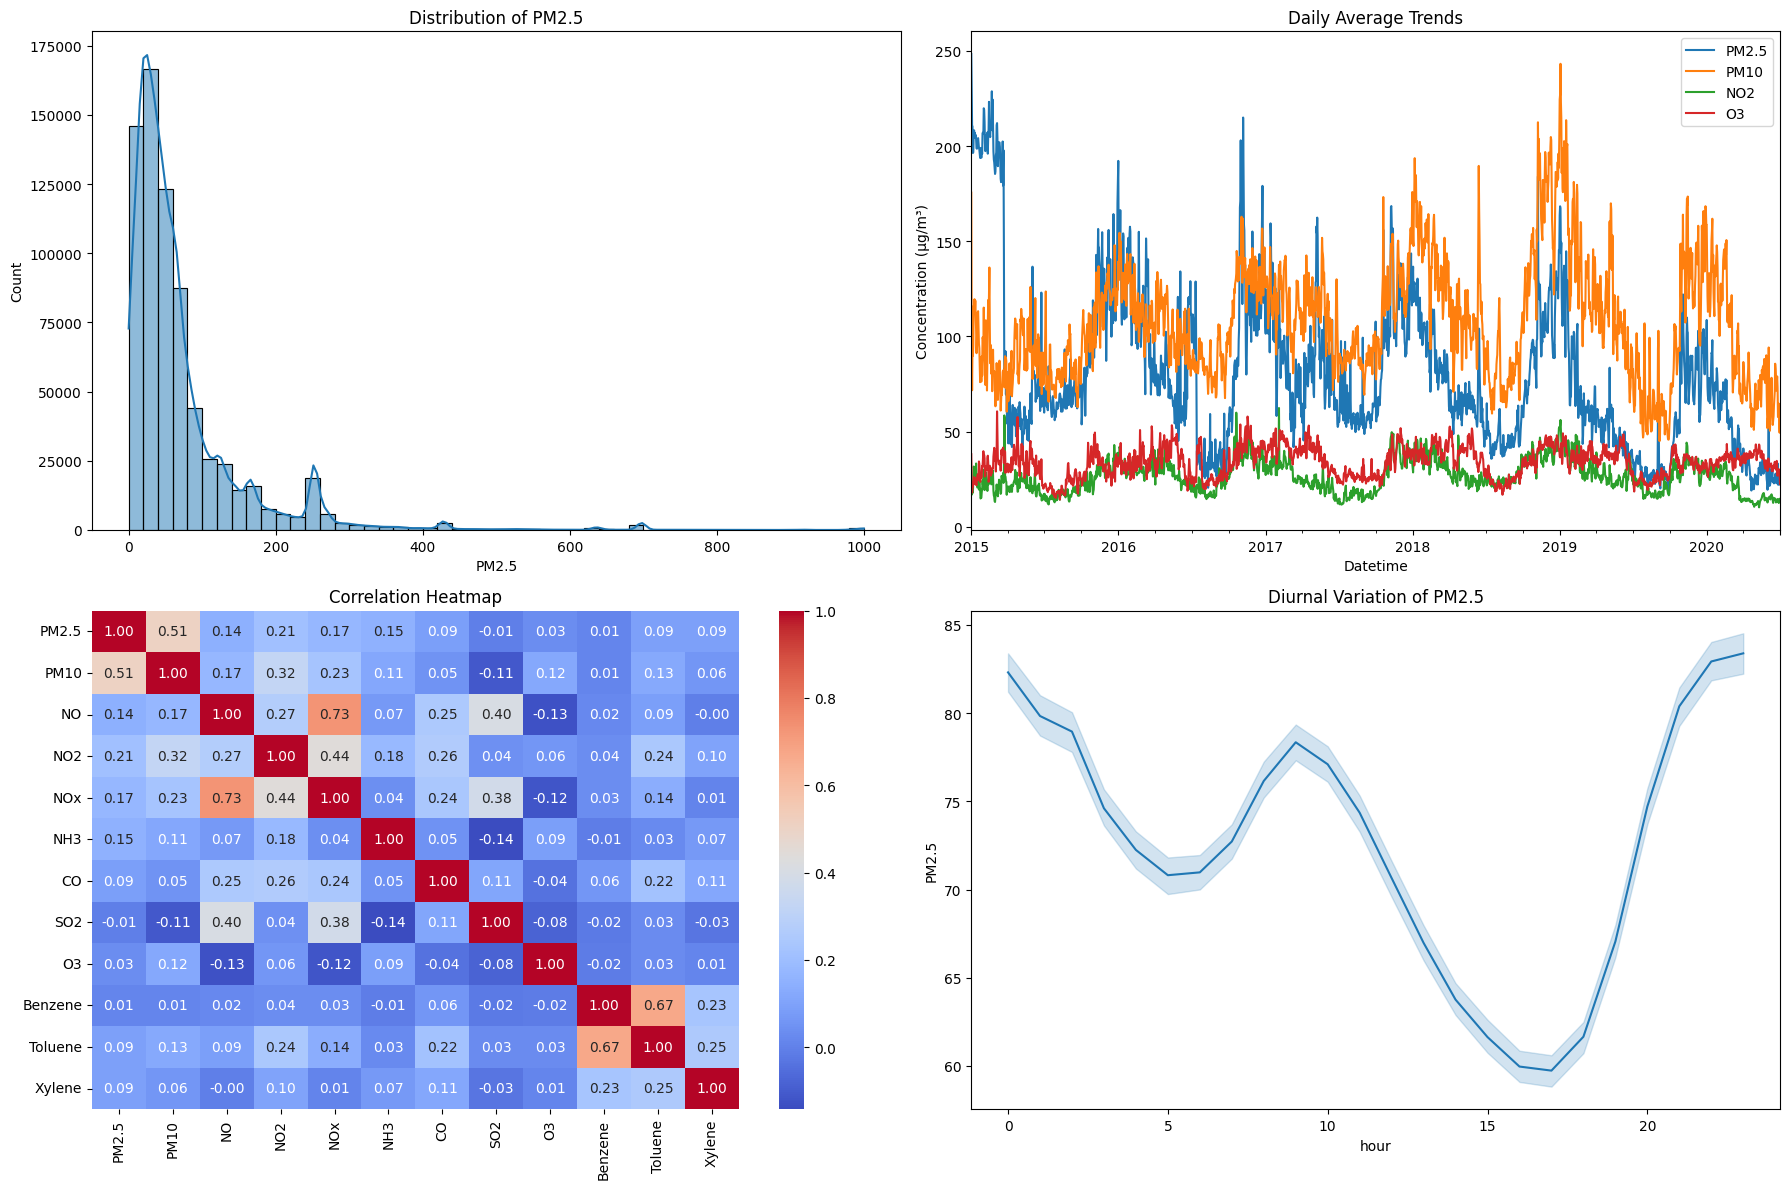

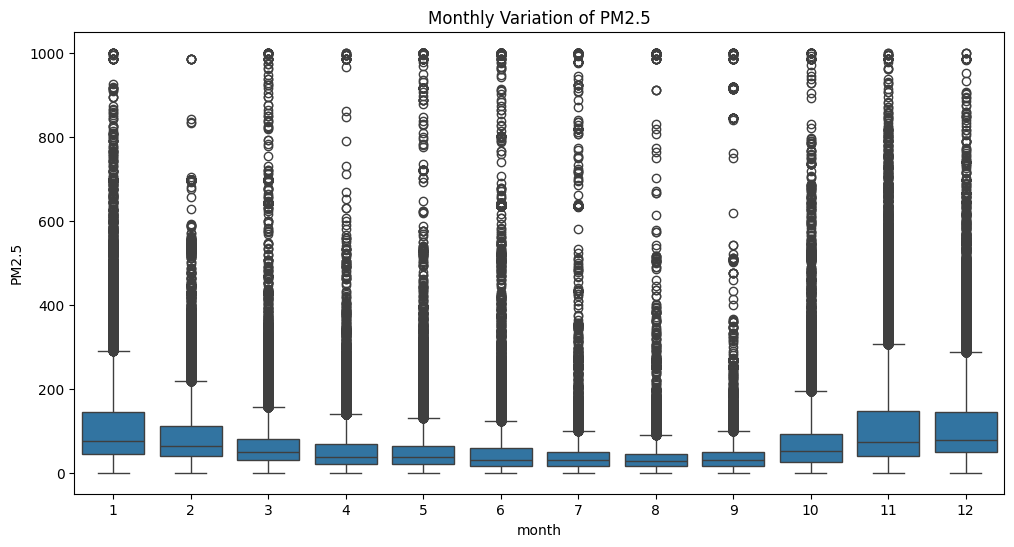

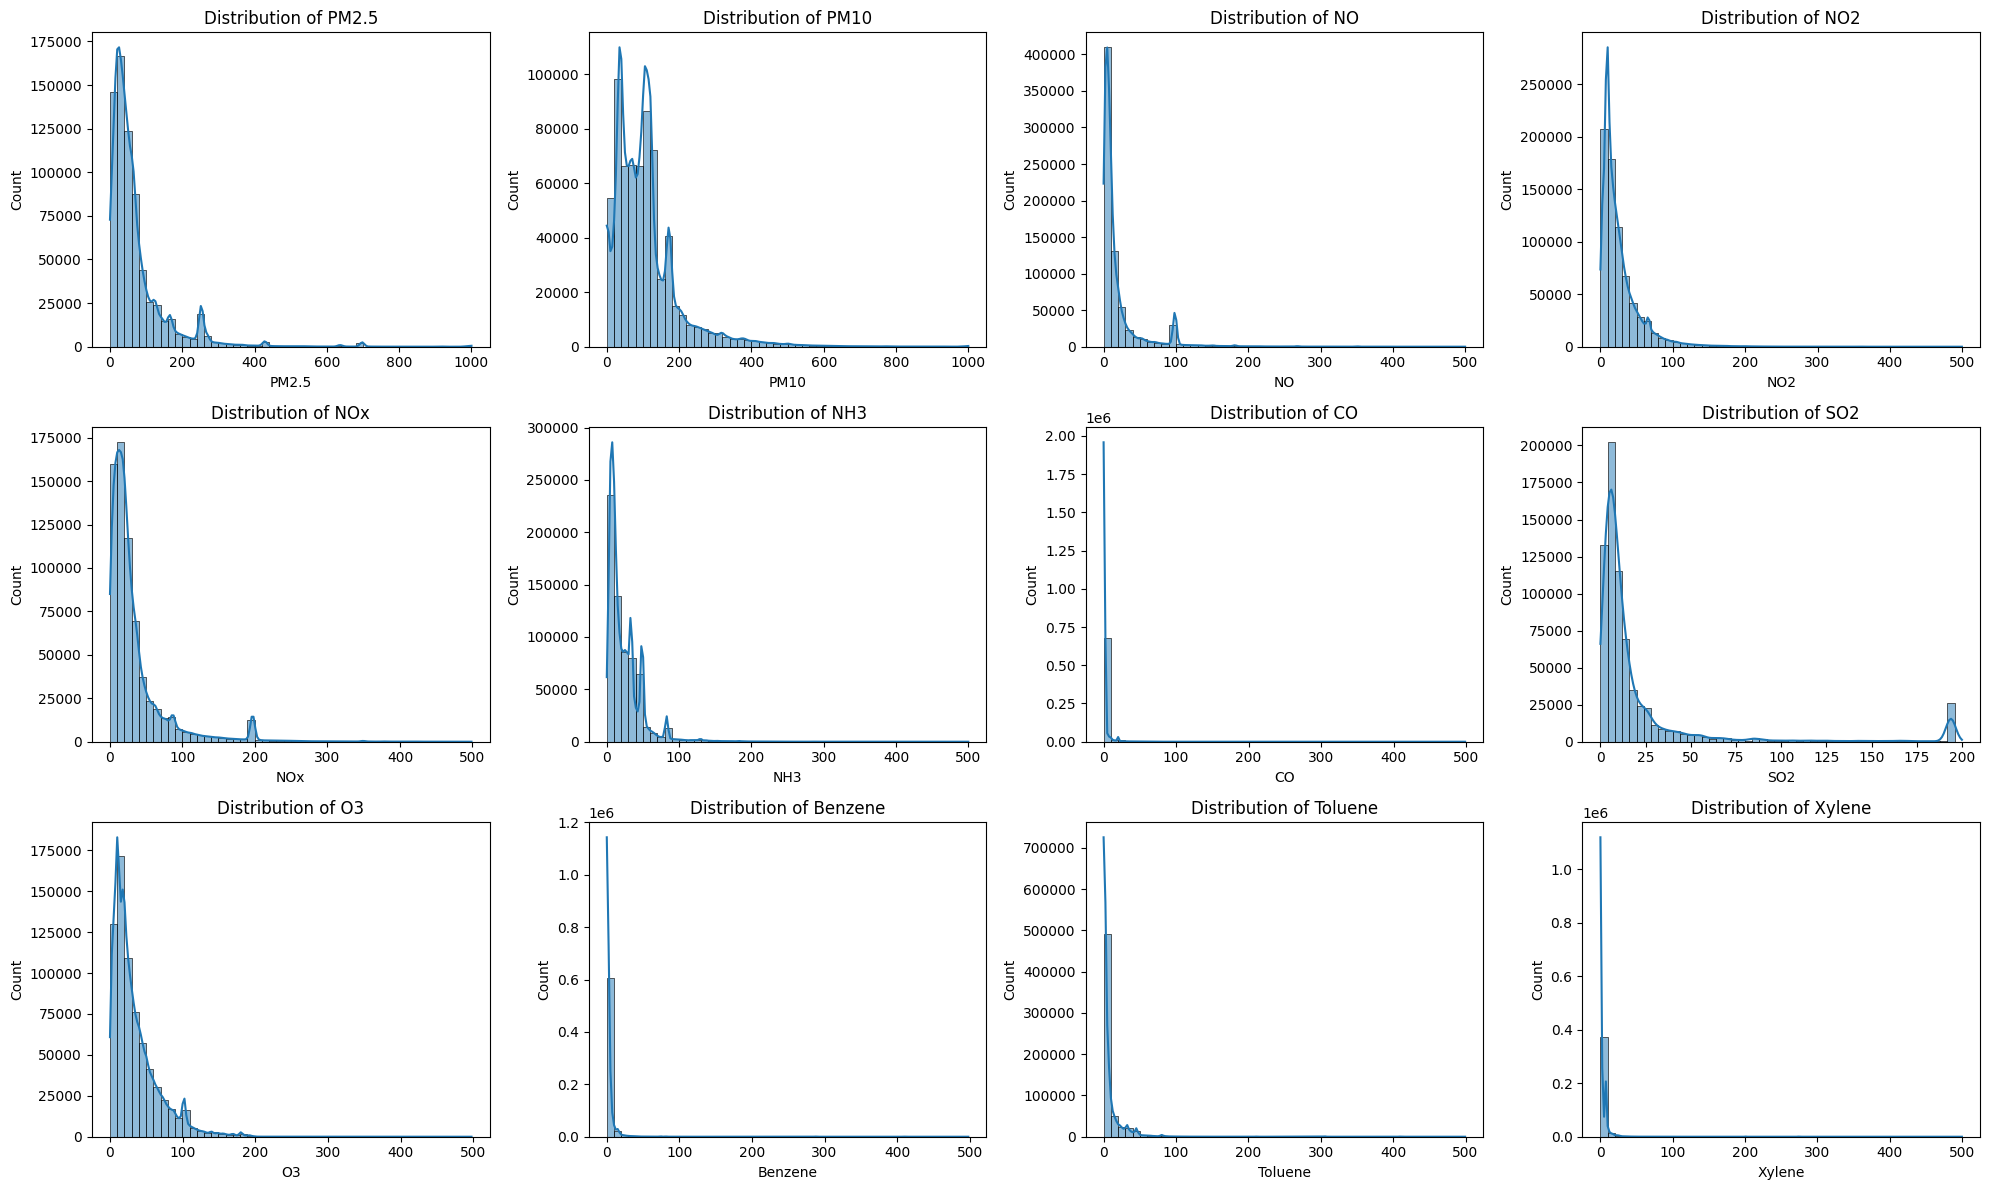

Summary Statistics Table:


,count,mean,std,min,25%,50%,75%,max
PM2.5,707875.0,72.551384,89.842799,0.01,23.25,46.00,82.79,999.99
PM10,659683.0,108.148415,95.230131,0.01,43.98,94.00,129.71,1000.00
NO,707875.0,20.717126,36.522967,0.01,3.78,8.27,18.67,499.99
NO2,707875.0,26.600508,28.856139,0.01,8.94,17.64,33.79,499.51
NOx,679850.0,34.608254,44.968532,0.00,10.46,20.51,38.02,498.61
NH3,659683.0,24.450727,27.881526,0.01,7.32,15.57,33.59,499.97
CO,707875.0,2.335015,11.103833,0.00,0.40,0.81,1.42,498.57
SO2,707875.0,21.872225,40.298986,0.01,4.91,8.55,17.00,199.96
O3,704023.0,34.154511,31.507686,0.01,11.45,24.05,46.47,497.62
Benzene,642442.0,3.657488,20.517759,0.00,0.02,0.74,2.75,498.07


In [ ]:
pollutants = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','Xylene']
df_daily = df[pollutants].resample('D').mean()
df['month'] = df.index.month
df['hour'] = df.index.hour

summary_table = df[pollutants].describe().T

fig, axs = plt.subplots(2, 2, figsize=(18,12))

# Distribution of PM2.5
sns.histplot(df['PM2.5'].dropna(), kde=True, bins=50, ax=axs[0,0])
axs[0,0].set_title("Distribution of PM2.5")

# Daily Trends of Major Pollutants
df_daily[['PM2.5','PM10','NO2','O3']].plot(ax=axs[0,1])
axs[0,1].set_title("Daily Average Trends")
axs[0,1].set_ylabel("Concentration (µg/m³)")

# Correlation Heatmap
sns.heatmap(df[pollutants].corr(), annot=True, cmap="coolwarm", fmt=".2f", ax=axs[1,0])
axs[1,0].set_title("Correlation Heatmap")

# Diurnal Pattern of PM2.5
sns.lineplot(x='hour', y='PM2.5', data=df, estimator='mean', ax=axs[1,1])
axs[1,1].set_title("Diurnal Variation of PM2.5")

plt.tight_layout()
plt.show()

# Full EDA
plt.figure(figsize=(12,6))
sns.boxplot(x='month', y='PM2.5', data=df)
plt.title("Monthly Variation of PM2.5")
plt.show()


num_cols = 4
num_rows = (len(pollutants) + num_cols - 1) // num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows*4))
axs = axs.flatten()

for i, col in enumerate(pollutants):
    sns.histplot(df[col].dropna(), kde=True, bins=50, ax=axs[i])
    axs[i].set_title(f"Distribution of {col}")

for j in range(i+1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

# Table
print("Summary Statistics Table:")
display(summary_table)


## Time-Series Resampling & Predictive Feature Engineering

In [ ]:
df_daily = df[pollutants].resample('D').mean().reset_index()
df_daily.rename(columns={'index':'Datetime'}, inplace=True)

for lag in [1, 2, 7, 14]:
    df_daily[f'PM2.5_lag{lag}'] = df_daily['PM2.5'].shift(lag)

df_daily['PM2.5_roll7'] = df_daily['PM2.5'].rolling(window=7).mean()
df_daily['PM2.5_roll30'] = df_daily['PM2.5'].rolling(window=30).mean()

df_daily['dayofweek'] = df_daily['Datetime'].dt.dayofweek
df_daily['month'] = df_daily['Datetime'].dt.month
df_daily['year'] = df_daily['Datetime'].dt.yearSo

df_features = df_daily.dropna().reset_index(drop=True)

print("Final feature dataset shape:", df_features.shape)
df_features.head()

Final feature dataset shape: (1980, 22)


,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,...,Xylene,PM2.5_lag1,PM2.5_lag2,PM2.5_lag7,PM2.5_lag14,PM2.5_roll7,PM2.5_roll30,dayofweek,month,year
0,2015-01-30,206.998214,98.764792,32.316786,22.140595,31.521429,21.847292,6.277976,61.090595,35.650298,...,2.375938,206.767560,195.924881,193.776786,200.384405,199.505663,204.001947,4,1,2015
1,2015-01-31,206.317083,87.839931,34.973750,26.675119,31.596905,20.448333,6.289226,64.332917,39.757024,...,2.961562,206.998214,206.767560,198.956012,203.453512,200.557245,202.601777,5,1,2015
2,2015-02-01,219.812798,115.171597,34.558631,30.030595,39.704464,25.468958,10.257381,53.698929,37.113690,...,7.691146,206.317083,206.998214,196.613631,204.174345,203.871412,202.357269,6,2,2015
3,2015-02-02,219.011548,89.969306,26.898988,22.672083,29.228631,23.586528,11.347917,49.147917,37.837857,...,9.827708,219.812798,206.317083,193.864048,201.580357,207.463912,202.636061,0,2,2015
4,2015-02-03,212.645952,85.678194,23.121429,19.331667,25.313869,21.152778,7.878036,45.558214,36.106190,...,3.471562,219.011548,219.812798,197.415298,199.048393,209.639719,202.712312,1,2,2015


In [ ]:
output_path = "/content/drive/MyDrive/Infosys_Spring_Board/Dataset/air_quality_features.csv"
df_features.to_csv(output_path, index=False)
print(f"Dataset saved successfully at: {output_path}")

Dataset saved successfully at: /content/drive/MyDrive/Infosys_Spring_Board/Dataset/air_quality_features.csv
